In [3]:
#DB
import os
import psycopg2

# Helpers
import numpy as np
from collections import defaultdict
import qgrid
from tqdm import tqdm_notebook
import time

# Preprocessing
from analyzer import python_analyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from vectorizer import NCutVectorizer

# Learning
from clustering import Clustering

# Evaluation
from sklearn.metrics import silhouette_samples, silhouette_score

In [4]:
import os
import ipyparallel as ipp

rc = ipp.Client()
rv = rc[:]
rc.ids

[0, 1, 2, 3]

## Data

In [5]:
topics = ["business", "entertainment", "politics", "sport", "tech"]
docs = []
base_path = "bbc"
for t in topics:
    docs_title = os.listdir("%s/%s" % (base_path,t))
    for item in docs_title:
        with open('%s/%s/%s' %(base_path, t, item), 'r') as txtfile:
            try:
                docs.append(txtfile.read())
            except UnicodeDecodeError:
                print("Error on doc %s/%s" % (t,item))

Error on doc sport/199.txt


In [6]:
# %load vectorizer.py
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from analyzer import python_analyzer
import numpy as np


class NCutVectorizer(object):
    def __init__(self, analyzer, binary, min_df):
        self.vectorizer = CountVectorizer(analyzer = 'word',
                                          binary=binary,
                                          min_df=min_df)

    def fit_transform(self, docs):
        train_data_features = self.vectorizer.fit_transform(docs)
        train_data_features = train_data_features.toarray()

        # Calculate NCut-weight
        doc_mat_norm = normalize(train_data_features)
        S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001
        D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])
        Y = np.dot(D, train_data_features.T)
        return Y.T


### Preprocessing solutions into bag of words ###

In [7]:
def create_bag_of_words(docs, vectorizer_method, binary=False, min_df=0.2):
#     vectorizer = vectorizer_method(analyzer = python_analyzer,
    vectorizer = vectorizer_method(analyzer = 'word',
                                   binary=binary,
                                   min_df=min_df) 
    train_data_features = vectorizer.fit_transform(docs)
    try:
        train_data_features = train_data_features.toarray()
    # It's already an array
    except AttributeError:
        pass
    return train_data_features

In [97]:
def run_clusters(*args):
    v, m, b, train_data_features, k, dist, method = args
    
    from clustering import Clustering
    import time
    from gap import Gap
    from sklearn.metrics import silhouette_samples, silhouette_score
    from coherence import calculate_umass_coherence
    
    clustering = Clustering(train_data_features, k, metric=dist)
    gap = Gap(train_data_features, k, nrefs=100, distance=dist)

    start = time.time()
    model, document_topic, word_topic = getattr(clustering, method)()
    clusters = document_topic.argmax(axis=1)

    # Compute Gap
    start = time.time()
    print("Started")
#             k_gap = gap.calculate_gap(clustering, method)
    k_gap  = [2,3]
    end = time.time()
    print("Gap took %d seconds" % (end-start))

    # Compute silhouette. Keep single to values to be able to plot it later
    k_silhouette = silhouette_score(train_data_features, clusters, metric=dist)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(train_data_features, clusters, metric=dist)

    # UMass coherence
    k_coherence = calculate_umass_coherence(train_data_features, word_topic, clusters, k)

    results_dict = {
        "model": model,
        "method": method,
        "vectorizer": v.__name__,
        "min_df": m,
        "binary": b,
        "gap": k_gap[0],
        "gap_error": k_gap[1],
        "k": k,
        "silhouette": k_silhouette,
        "silhouette_samples": sample_silhouette_values,
        "X": train_data_features,
        "y": clusters,
        "distance": dist,
        "coherence": k_coherence
    }
    return results_dict

In [98]:
%%time

vectorizers = [CountVectorizer]
               #TfidfVectorizer, 
#                NCutVectorizer]
# min_df = np.arange(0.05, 0.5, 0.05)
min_df = [0.25]
binary = [True]
          #, False]
cluster_methods = ['nmf']
                   #'lda']
#, 'hierarchical', 'gaussian_mixture', 'spectral_clustering']
metric = ['cosine']
          #, 'euclidean', 'cosine']

results = []

# Sequences to be sent to map function
vectorizer_map = []
min_df_map = []
binary_map = []
train_data_features_map = []
clusters_map = []
metric_map = []
method_map = []
args = [vectorizer_map, min_df_map, binary_map, train_data_features_map, clusters_map, metric_map, method_map]
    
# Grid search
for v in vectorizers:
    for m in min_df:
        for b in binary:
            train_data_features = create_bag_of_words(docs, v, binary=b, min_df=m)
            
            # Remove rows containing only zeros (weird exercises)
            solution_sample = train_data_features[~(train_data_features==0).all(1)]
            if solution_sample.shape != train_data_features.shape:
                error = {
                    "vectorizer": v,
                    "min_df": m,
                    "binary": b
                }
                print("ERROR: %s" % error)
            
#             clusters = range(2, (min(train_data_features.shape)+1)//2)
            clusters = range(2, 6)
            for k in tqdm_notebook(clusters, desc='k'):
                for dist in metric:
                    for method in cluster_methods:
                        vectorizer_map.append(v)
                        min_df_map.append(m)
                        binary_map.append(b)
                        train_data_features_map.append(train_data_features)
                        clusters_map.append(k)
                        metric_map.append(dist)
                        method_map.append(method)
result_dict = rv.map(run_clusters, *args)


CPU times: user 764 ms, sys: 4 ms, total: 768 ms
Wall time: 763 ms


In [100]:
result_dict[1]

{'X': array([[1, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 1, 1, 1]]),
 'binary': True,
 'coherence': ([-1.2377659307200197, -0.8379218322517508, -0.8666579768780599],
  -0.8666579768780599,
  0.1820934383138543),
 'distance': 'cosine',
 'gap': 2,
 'gap_error': 3,
 'k': 3,
 'method': 'nmf',
 'min_df': 0.25,
 'model': NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
   n_components=3, random_state=2701860826, shuffle=False, solver='cd',
   tol=0.0001, verbose=0),
 'silhouette': 0.0040320195457692375,
 'silhouette_samples': array([-0.06475809, -0.16115664, -0.19281706, ...,  0.17538332,
        -0.03506637,  0.26416927]),
 'vectorizer': 'CountVectorizer',
 'y': array([0, 0, 2, ..., 1, 0, 1])}

In [16]:
import pandas as pd

In [48]:
df = pd.DataFrame(results)

In [49]:
qgrid.show_grid(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [50]:
# gaps = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'NCutVectorizer') & (df['binary'] == True)]['gap'].values.tolist()
# error = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'NCutVectorizer') & (df['binary'] == True)]['gap_error'].values.tolist()
gaps = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['binary'] == True)]['gap'].values.tolist()
error = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['binary'] == True)]['gap_error'].values.tolist()
sils = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['binary'] == True)]['silhouette'].values.tolist()
coherence = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['binary'] == True)]['coherence'].values.tolist()
error

[0.0009409219119736749,
 0.0011224633301174691,
 0.001057348108306223,
 0.0008794589669268222,
 0.0006274315168419504,
 0.0007403985141614147,
 0.0007382404235781261,
 0.0009553377499087896,
 0.001157199442108274]

In [51]:
def define_k(gaps, error):
    for i in range(2,len(gaps)):
        k = i-2
        gapi = gaps[k]
        gapi1 = gaps[k+1]
        std = error[k+1]
        
        if gapi >= (gapi1-std):
            print("k = %d" % (k+2))
            break
            
    diff = np.array(gaps) - np.array(error)
    gaps[1:] = gaps[:-1]
    gap_diff = np.array(gaps) > diff
    k = np.argmax(gap_diff[1:] == True)
    print("k = %d" % (k+2))

<IPython.core.display.Javascript object>


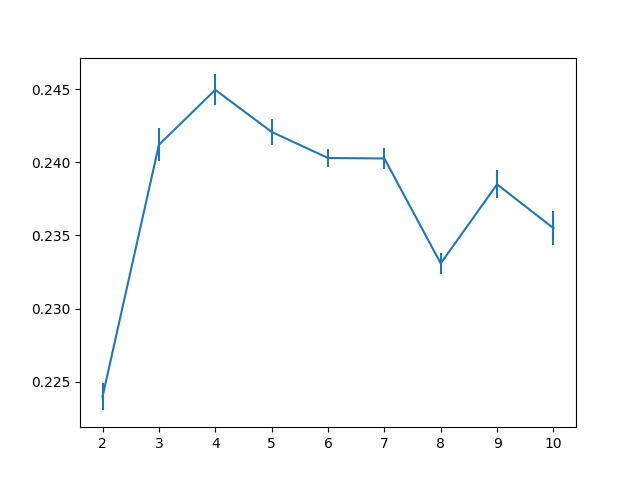

k = 4
k = 4


In [52]:
import matplotlib.pyplot as plt
%matplotlib notebook

# Plot data
plt.errorbar(range(2,len(gaps)+2), gaps, yerr=error)
plt.show()

# Get best k
k = define_k(gaps, error)

<IPython.core.display.Javascript object>


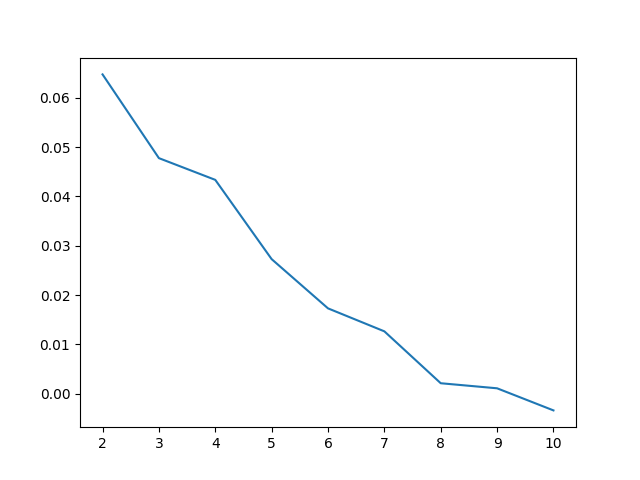

k = 2


In [53]:
# Plot data
plt.figure()
plt.plot(range(2,len(sils)+2), sils)
plt.show()

# Get best k
k = np.argmax(np.asarray(sils))+2
print("k = %d" % k)

In [ ]:
%%time

# Calculate coherence
coherence, error = calculate_umass_coherence(data_X, k_max)

# Plot data
plt.errorbar(range(1,len(coherence)+1), coherence, yerr=error)
# plt.show()

# Get best k
k = get_curve_knee(range(1,len(coherence)+1), coherence)
print("k = %d" % (k+1))

In [ ]:
import pickle

with open("clustering_bcc.pkl", "wb") as pklfile:
    pklfile.dump(df)

In [9]:
from scipy.spatial.distance import pdist
import scipy
import numpy as np

class Gap(object):
    def __init__(self, data, k, nrefs=20, distance='cosine'):
        self._prepare_ref_dataset(data, nrefs)
        self.k = k
        self.X = data
        self.distance = distance
        
    def _prepare_ref_dataset(self, data, nrefs=20):
        shape = data.shape
        # Set bounding box
        tops = data.max(axis=0)
        bots = data.min(axis=0)

        # Generate distribution
        self.refs = scipy.random.random_sample(size=(shape[0],shape[1],nrefs))

        # Set offset for random uniform samples to be inside bounding boxes
        dists = scipy.matrix(scipy.diag(tops-bots))
        for i in range(nrefs):
            self.refs[:,:,i] = self.refs[:,:,i]*dists+bots

        return self.refs
    
    def calculate_wk(self, X, y):
        """ Calculate nr, dr and wk """
        min_k = np.array(y).min()
        max_k = np.array(y).max()
        wk = []

        for i in range(min_k, max_k+1):
            # Calculate Dr for each cluster
            obs_idx = np.where(y == i)[0]
            nr = obs_idx.shape[0]

    #         if nr == 0:
    #             raise TypeError("There are empty clusters.")

            # Get pairwise distance
            dist = pdist(X[obs_idx], self.distance).sum()

            # Calculate Wk
            wki = dist/(2*nr)
            wk.append(wki)

        return np.array(wk).sum()
    
    def calculate_ref_wk(self, method, k):
        self.wk_refs = []
        
        for ref in range(self.refs.shape[2]):
            ref_clustering = Clustering(self.refs[:,:,ref], k)
            model, document_topic, word_topic = getattr(ref_clustering, method)()
            clusters = ref_clustering.document_topic.argmax(axis=1)
            wk_ref = self.calculate_wk(self.refs[:,:,ref], clusters)
            log_wk_ref = np.log(wk_ref)
            self.wk_refs.append(log_wk_ref)
            
        return self.wk_refs
            
    def calculate_gap(self, clustering, method):
        # Calculate Wk for original data
        clusters = clustering.document_topic.argmax(axis=1)
        wk = self.calculate_wk(self.X, clusters)
        log_wk = np.log(wk)

        # Calculate Wk for reference distribution
        wk_refs = self.calculate_ref_wk(method, self.k)
        wkb = np.array(wk_refs)
        wkb_sum = wkb.sum()
        wkb_std = wkb.std()
        B = wkb.shape[0]

        # Calculate Gap
        gap_k = (1/B*wkb_sum) - log_wk
        error = wkb_std*np.sqrt(1+(1/B))

        return gap_k, error

In [10]:
def calculate_umass_coherence(X, clusters, k):
    k_coherence = []
    for idx_cluster in range(k):
        cluster_data = X[clusters == idx_cluster]
        score = np.log((cluster_data+1e-12)/cluster_data.sum(axis=1))
        k_coherence.append(score.sum())
    return np.mean(k_coherence), np.std(k_coherence)

In [11]:
def get_curve_knee(x, y):
    """ Source: inding a “Kneedle” in a Haystack: Detecting Knee Points in System Behavior 
    https://raghavan.usc.edu//papers/kneedle-simplex11.pdf"""
    
    # Set baseline curve
    x_init, y_init = x[0], y[0]
    x_final, y_final = x[-1], y[-1]
    # Plot it
    plt.plot([x_init, x_final], [y_init, y_final])
    
    # Calculate line coefficients
    a = (y_final - y_init)/(x_final - x_init)
    b = y_init - a*x_init
    y_baseline_list = []
    diff = []
    for idx in range(len(x)):
        x_baseline = x[idx]
        y_baseline = a*x_baseline + b
        y_baseline_list.append(y_baseline)
        diff.append(abs(y[idx] - y_baseline))
        plt.plot([x[idx], x_baseline], [y[idx], y_baseline], c='gray')
        
    # Get optimal value
    max_diff = max(diff)
    max_diff_idx = diff.index(max_diff)
    plt.plot([x[max_diff_idx], x[max_diff_idx]], [y[max_diff_idx], y_baseline_list[max_diff_idx]], c='red')
    
    # Return optimal number of components
    return max_diff_idx